# Import librairies

In [2]:
import datetime
import folium
from folium.features import GeoJsonPopup   
from folium import Choropleth
import geopandas as gpd
from geopandas import sjoin
import geopy
from geopy.distance import geodesic
!pip install holidays
import holidays
from IPython.display import display, clear_output
import ipywidgets as widgets
import json 
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors 
from matplotlib.lines import Line2D 
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import LineString
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set_style("white")
sns.despine()
pd.set_option('display.max_columns', None)  # It tells Pandas to display all columns, regardless of how many there are


<Figure size 640x480 with 0 Axes>

# Gathering data

In [3]:
CBS_2021_2023_Full_df = pd.read_csv("CBS_2021-2023_Full.csv")
CBS_2021_2023_Full_df.head(3)


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/2205261759.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  CBS_2021_2023_Full_df = pd.read_csv("CBS_2021-2023_Full.csv")


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.89460,-77.072305,member
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.96000,-77.020000,casual
2,E74069873161EE33,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.92087,-77.031691,member


# Data Wrangling

Check info and dtypes of the dataframe

In [4]:
CBS_2021_2023_Full_df.shape

(10693997, 13)

In [5]:
print("Info of the DataFrame:\n", '\n')
CBS_2021_2023_Full_df.info()

Info of the DataFrame:
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693997 entries, 0 to 10693996
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.0+ GB


Check unique values before conversion

In [6]:
unique_values_before = CBS_2021_2023_Full_df.nunique()
print("Unique values before conversion:\n", unique_values_before, '\n')

Unique values before conversion:
 ride_id               10693997
rideable_type                3
started_at             9649173
ended_at               9638365
start_station_name         860
start_station_id          1891
end_station_name           865
end_station_id            1904
start_lat               570110
start_lng               617671
end_lat                 173835
end_lng                 183886
member_casual                2
dtype: int64 



Check Memory usage before converting

In [7]:
memory_usage = CBS_2021_2023_Full_df.memory_usage(deep=True)
print("Memory Usage before Converting dtypes:\n", memory_usage, '\n')

Memory Usage before Converting dtypes:
 Index                       132
ride_id               695109805
rideable_type         654238494
started_at            727191796
ended_at              727191796
start_station_name    740478725
start_station_id      343549594
end_station_name      736905216
end_station_id        343530364
start_lat              85551976
start_lng              85551976
end_lat                85551976
end_lng                85551976
member_casual         588169835
dtype: int64 



Converting to reduce the in-memory footprint of the dataset

In [8]:
# Copy the dataframe
CBS_df = CBS_2021_2023_Full_df.copy()

# Convert categorical columns to category type for memory efficiency
CBS_df["rideable_type"] = CBS_df["rideable_type"].astype("category")
CBS_df["start_station_name"] = CBS_df["start_station_name"].astype("category")
CBS_df["end_station_name"] = CBS_df["end_station_name"].astype("category")
CBS_df["member_casual"] = CBS_df["member_casual"].astype("category")

# Convert started_at and ended_at to started_attime for memory efficiency
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'])
CBS_df['ended_at'] = pd.to_datetime(CBS_df['ended_at'])

# Regenerate the entire ride_id column with sequential integers and convert it
# to a memory-efficient data type (uint32)
CBS_df['ride_id'] = pd.Series(range(1, len(CBS_df) + 1), dtype='uint32')


Check info and dtypes after conversion

In [9]:
info_after = CBS_df.info()
print("Info of the DataFrame after conversion:\n", info_after, '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693997 entries, 0 to 10693996
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             uint32        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    object        
 6   end_station_name    category      
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
dtypes: category(4), datetime64[ns](2), float64(4), object(2), uint32(1)
memory usage: 754.8+ MB
Info of the DataFrame after conversion:
 None 



Check unique values after conversion

In [10]:
unique_values_after = CBS_df.nunique()
print("Unique values after conversion:\n", unique_values_after, '\n')

Unique values after conversion:
 ride_id               10693997
rideable_type                3
started_at             9649173
ended_at               9638365
start_station_name         860
start_station_id          1891
end_station_name           865
end_station_id            1904
start_lat               570110
start_lng               617671
end_lat                 173835
end_lng                 183886
member_casual                2
dtype: int64 



Check memory usage after all conversions

In [11]:
print("Memory Usage after Converting dtype:\n", CBS_df.memory_usage(deep=True), '\n')

Memory Usage after Converting dtype:
 Index                       132
ride_id                42775988
rideable_type          10694288
started_at             85551976
ended_at               85551976
start_station_name     21485201
start_station_id      343549594
end_station_name       21485559
end_station_id        343530364
start_lat              85551976
start_lng              85551976
end_lat                85551976
end_lng                85551976
member_casual          10694215
dtype: int64 



Calculate how much we reduced the in-memory footprint of the dataset

In [12]:
reduction = CBS_df.memory_usage(deep=True).sum() / CBS_2021_2023_Full_df.memory_usage(deep=True).sum()
print(f"We reduced the in-memory footprint of the dataset to {reduction:.2f} of its original size.")

We reduced the in-memory footprint of the dataset to 0.22 of its original size.


Identify Missing Values

In [13]:
CBS_df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

Drop rows with missing values

In [14]:
CBS_df.dropna(inplace=True)
CBS_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member


Duplicates

In [15]:
duplicate_rows = CBS_df.duplicated().shape
print(duplicate_rows)

(9572692,)


Dataframe Description

In [16]:
CBS_df.describe()

,ride_id,started_at,ended_at,start_lat,start_lng,end_lat,end_lng
count,9.572692e+06,9572692,9572692,9.572692e+06,9.572692e+06,9.572692e+06,9.572692e+06
mean,5.276689e+06,2022-09-07 21:12:58.837073920,2022-09-07 21:33:37.753500672,3.890221e+01,-7.703229e+01,3.890110e+01,-7.703184e+01
min,1.000000e+00,2021-01-01 00:08:33,2021-01-01 00:21:00,3.878255e+01,-7.736889e+01,0.000000e+00,-7.736845e+01
25%,2.682149e+06,2021-12-17 12:07:41.750000128,2021-12-17 12:24:13.750000128,3.889050e+01,-7.704478e+01,3.889046e+01,-7.704478e+01
50%,5.245088e+06,2022-09-14 21:35:49.500000,2022-09-14 21:59:20,3.890240e+01,-7.703189e+01,3.890176e+01,-7.703188e+01
75%,7.856468e+06,2023-06-08 07:47:58.750000128,2023-06-08 07:59:30.750000128,3.891266e+01,-7.701392e+01,3.891127e+01,-7.701377e+01
max,1.069400e+07,2023-12-31 23:59:30,2024-01-01 15:24:35,3.912591e+01,-7.682551e+01,3.912583e+01,0.000000e+00
std,3.029277e+06,NaN,NaN,2.588960e-02,3.296177e-02,5.050415e-02,9.224220e-02


# Create new features

Create a new feature: "Season":
Winter 12-02
Spring 03-05
Fall 09-11
Summer 06-08

In [17]:
# Ensure the 'Date' column is datetime
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'], format="%d-%m-%Y %H:%M")

# Function to map months to seasons
def get_season(row):
    if row['started_at'].year in [2021, 2022, 2023]:  # correct year range
        month = row['started_at'].month
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
    else:
        return 'Unknown'  # optional: handle years outside 2021–2023

# Apply the function to create a new column
CBS_df['season'] = CBS_df.apply(get_season, axis=1)

# Convert to categorical with ordered categories
CBS_df['season'] = pd.Categorical(
    CBS_df['season'],
    categories=['Winter', 'Spring', 'Summer', 'Fall'],
    ordered=True
)

CBS_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,Winter
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,Winter
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,Winter
4,5,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member,Winter
6,7,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,31617.0,Good Hope Rd & MLK Ave SE,31802.0,38.900413,-76.982872,38.867373,-76.988039,casual,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693991,10693992,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,Lincoln Park / 13th & East Capitol St NE,31619.0,38.884095,-76.995234,38.890461,-76.988355,casual,Winter
10693992,10693993,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,31955.0,Market Square / King St & Royal St,31042.0,38.806002,-77.055911,38.804718,-77.043363,member,Winter
10693993,10693994,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,Lincoln Park / 13th & East Capitol St NE,31619.0,38.884185,-76.995396,38.890461,-76.988355,member,Winter
10693994,10693995,classic_bike,2023-12-31 23:59:27,2024-01-01 02:09:11,22nd & P ST NW,31285.0,23rd & E St NW,31260.0,38.909394,-77.048728,38.896104,-77.049882,casual,Winter


In [18]:
unique_values_after = CBS_df.nunique()
print("Unique values after conversion:\n", unique_values_after, '\n')

Unique values after conversion:
 ride_id               9572692
rideable_type               3
started_at            8711772
ended_at              8701740
start_station_name        858
start_station_id         1883
end_station_name          864
end_station_id           1899
start_lat              508855
start_lng              552596
end_lat                144744
end_lng                152212
member_casual               2
season                      4
dtype: int64 



Create a new feature: "Days_Off"

In [19]:
# Ensure 'Date' column is datetime
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'])

# Define your country's holidays – here for the US (customize if needed)
us_holidays = holidays.US(years=[2021, 2022, 2023])

CBS_df['Days_Off'] = (
    CBS_df['started_at'].dt.date.isin(us_holidays) |
    (CBS_df['started_at'].dt.weekday >= 5)
)
CBS_df['Days_Off'] = CBS_df['Days_Off'].map({True: "Yes", False: "No"})

CBS_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,Winter,Yes
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,Winter,Yes
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,Winter,Yes
4,5,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member,Winter,Yes
6,7,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,31617.0,Good Hope Rd & MLK Ave SE,31802.0,38.900413,-76.982872,38.867373,-76.988039,casual,Winter,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693991,10693992,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,Lincoln Park / 13th & East Capitol St NE,31619.0,38.884095,-76.995234,38.890461,-76.988355,casual,Winter,Yes
10693992,10693993,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,31955.0,Market Square / King St & Royal St,31042.0,38.806002,-77.055911,38.804718,-77.043363,member,Winter,Yes
10693993,10693994,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,Lincoln Park / 13th & East Capitol St NE,31619.0,38.884185,-76.995396,38.890461,-76.988355,member,Winter,Yes
10693994,10693995,classic_bike,2023-12-31 23:59:27,2024-01-01 02:09:11,22nd & P ST NW,31285.0,23rd & E St NW,31260.0,38.909394,-77.048728,38.896104,-77.049882,casual,Winter,Yes


Create a new feature: ride_duration

In [20]:
# Ensure datetime format
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'])
CBS_df['ended_at'] = pd.to_datetime(CBS_df['ended_at'])

# Calculate duration in minutes
CBS_df['ride_duration_min'] = (CBS_df['ended_at'] - CBS_df['started_at']).dt.total_seconds() / 60
CBS_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off,ride_duration_min
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,Winter,Yes,25.333333
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,Winter,Yes,14.216667
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,Winter,Yes,5.583333


In [21]:
unique_values_after = CBS_df.nunique()
print("Unique values after conversion:\n", unique_values_after, '\n')

Unique values after conversion:
 ride_id               9572692
rideable_type               3
started_at            8711772
ended_at              8701740
start_station_name        858
start_station_id         1883
end_station_name          864
end_station_id           1899
start_lat              508855
start_lng              552596
end_lat                144744
end_lng                152212
member_casual               2
season                      4
Days_Off                    2
ride_duration_min       35508
dtype: int64 



# create Plot

Plot Bike Ride vs. Hours

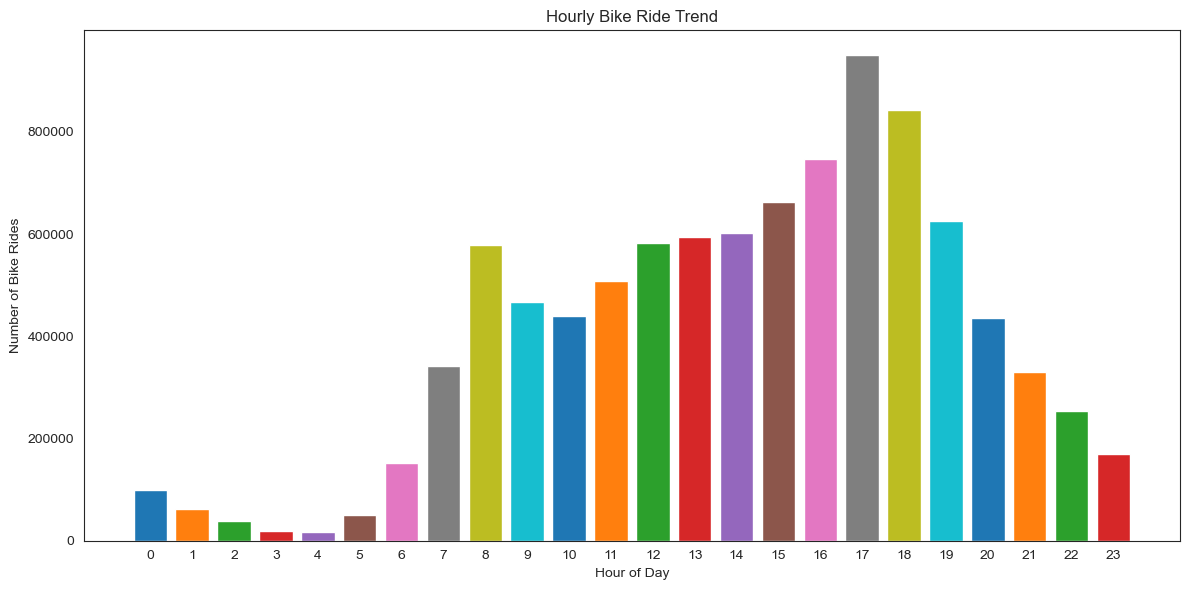

In [22]:
# 1. Convert 'started_at' to datetime with the correct format
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 3. Extract hour of the day
CBS_df['hour'] = CBS_df['started_at'].dt.hour

# 4. Count number of rides by hour
data = CBS_df['hour'].value_counts().sort_index()

# 5. Prepare labels and color cycle
labels = data.index.astype(str)
colors = plt.cm.tab10.colors
color_cycle = [colors[i % len(colors)] for i in range(len(data))]


# 6. Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, data.values, color=color_cycle)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Bike Rides")
plt.title("Hourly Bike Ride Trend")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Plot Bike Ride vs. Hours vs. Days off

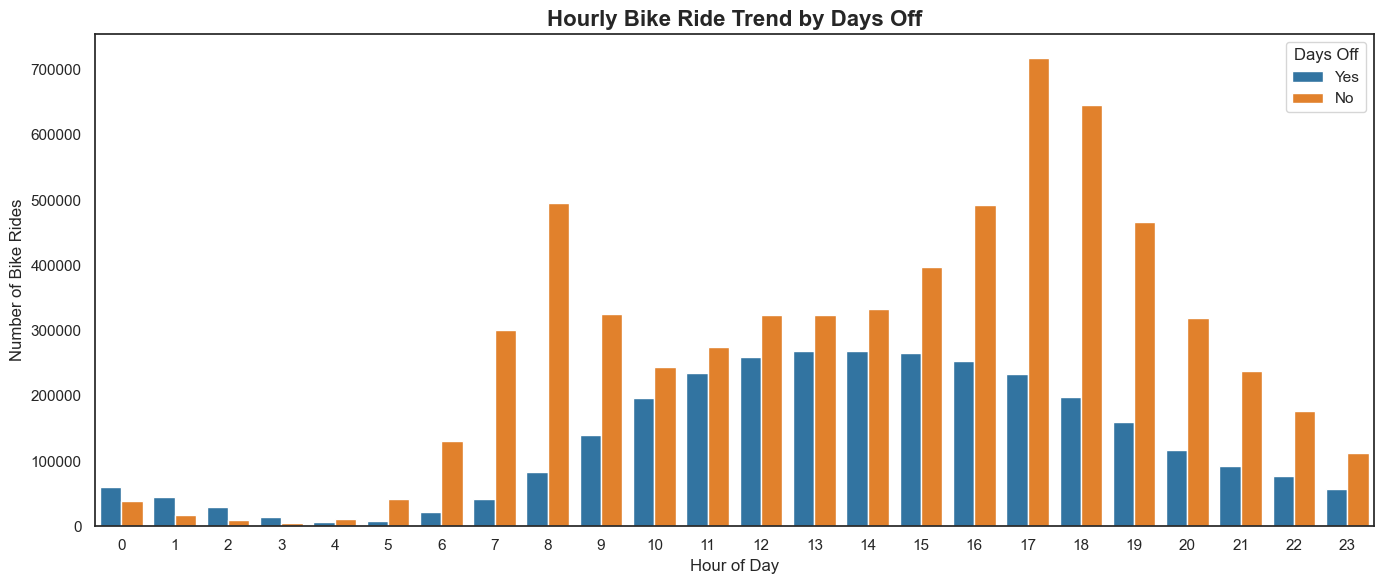

In [90]:
# 3. Plot using seaborn
plt.figure(figsize=(14, 6))
sns.countplot(data=CBS_df, x='hour', hue='Days_Off', palette='tab10')

# 4. Beautify
plt.xlabel("Hour of Day")
plt.ylabel("Number of Bike Rides")
plt.title("Hourly Bike Ride Trend by Days Off", fontsize=16, weight='bold', loc='center')
plt.xticks(rotation=0)
plt.legend(title="Days Off")
plt.tight_layout()
plt.show()


Plot Bike Ride vs Month vs Member

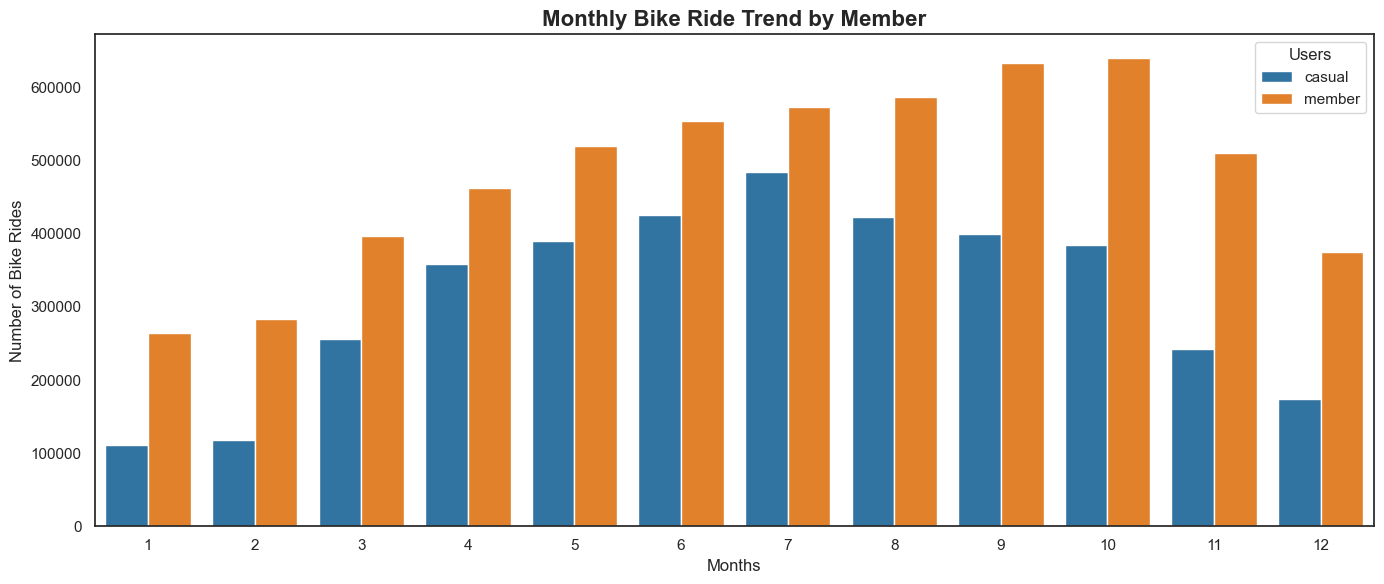

In [89]:
# 1. Ensure datetime format
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extract month
CBS_df['month'] = CBS_df['started_at'].dt.month

# 3. Plot using seaborn
plt.figure(figsize=(14, 6))
sns.countplot(data=CBS_df, x='month', hue='member_casual', palette='tab10')

# 4. Beautify
plt.xlabel("Months")
plt.ylabel("Number of Bike Rides")
plt.title("Monthly Bike Ride Trend by Member", fontsize=16, weight='bold', loc='center')
plt.xticks(rotation=0)
plt.legend(title="Users")
plt.tight_layout()
plt.show()


Plot Bike Rides vs Hour vs Season

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/716478179.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = CBS_df.groupby(['hour', 'season']).size().reset_index(name='ride_count')


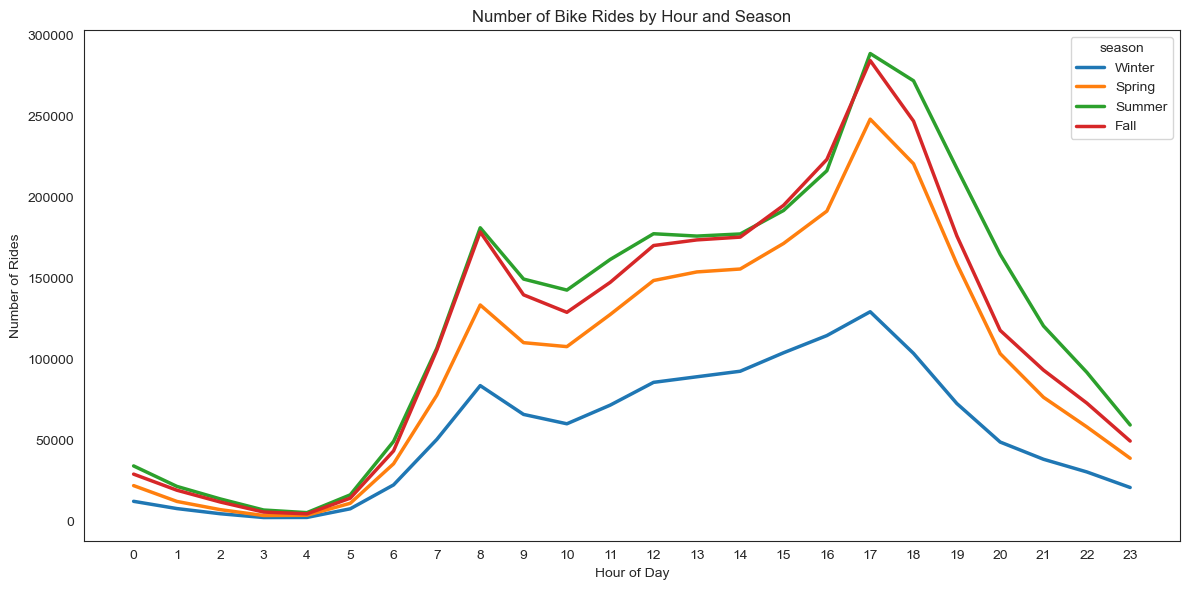

In [25]:

# Group by hour and season, then count the number of rides
df = CBS_df.groupby(['hour', 'season']).size().reset_index(name='ride_count')

# Plot with seaborn using hue for season
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='ride_count', hue='season', palette='tab10', linewidth=2.5)
plt.title("Number of Bike Rides by Hour and Season")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



Plot Average Duration vs Hour vs Season

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/1655333757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_duration = CBS_df.groupby(['hour', 'season'])['ride_duration_min'].mean().reset_index()


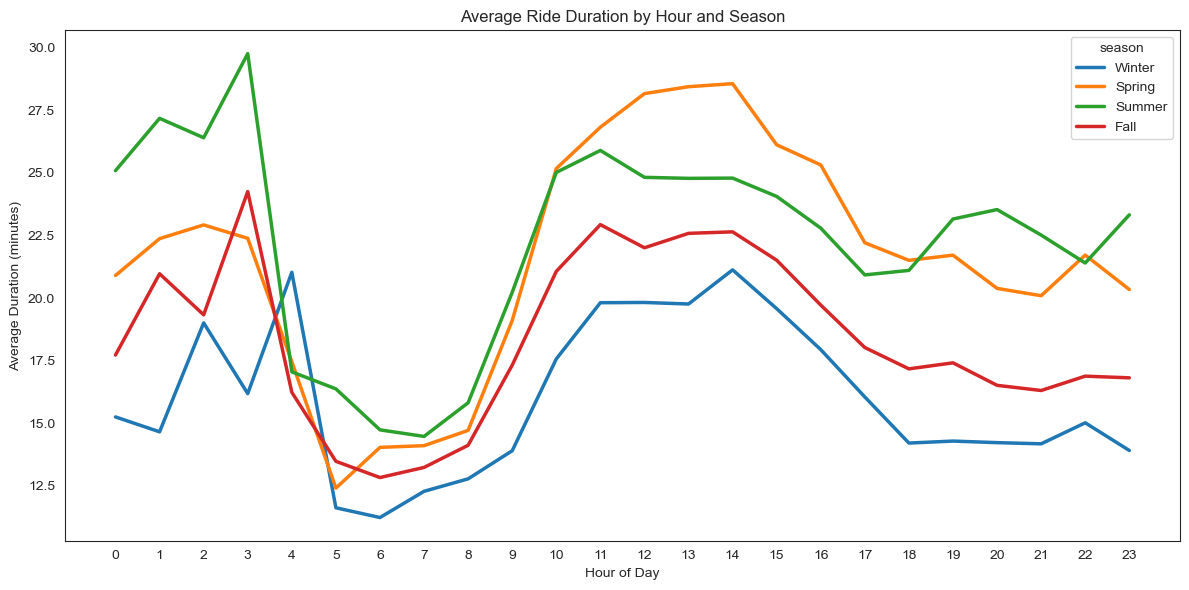

In [26]:
df_duration = CBS_df.groupby(['hour', 'season'])['ride_duration_min'].mean().reset_index()

# Plot average ride duration by hour and season (cleaner version)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_duration,
    x='hour',
    y='ride_duration_min',
    hue='season',
    palette='tab10',
    linewidth=2.5  # thicker, smoother lines
)
plt.title("Average Ride Duration by Hour and Season")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration (minutes)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


WMATA offers service on 14 routes around the clock serving all eight DC wards. Buses operate every 20 minutes.
No trains from 1 AM to 5 AM.

In [27]:
unique_values_after = CBS_df.nunique()
print("Unique values after conversion:\n", unique_values_after, '\n')

Unique values after conversion:
 ride_id               9572692
rideable_type               3
started_at            8711772
ended_at              8701740
start_station_name        858
start_station_id         1883
end_station_name          864
end_station_id           1899
start_lat              508855
start_lng              552596
end_lat                144744
end_lng                152212
member_casual               2
season                      4
Days_Off                    2
ride_duration_min       35508
hour                       24
month                      12
dtype: int64 



Plot with Time Selection: Total rides in January 2023

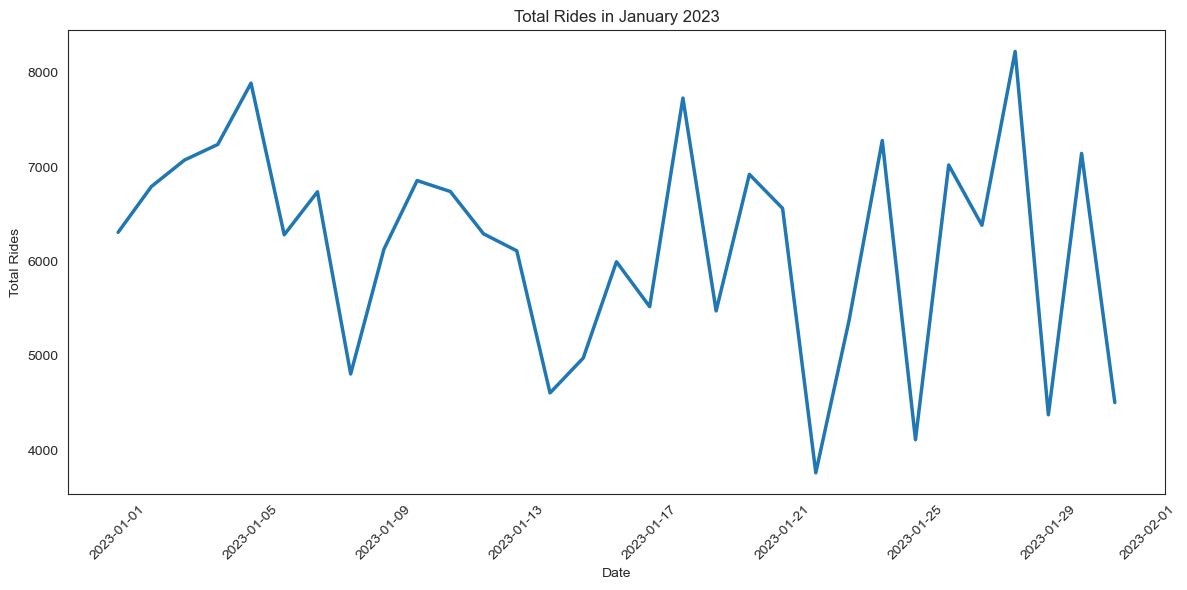

In [28]:
# Convert 'started_at' column to datetime
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filter for rides in January 2023
jan_2023_df = CBS_df[(CBS_df['started_at'].dt.year == 2023) & (CBS_df['started_at'].dt.month == 1)]

# Count rides per day
df = jan_2023_df.groupby(jan_2023_df['started_at'].dt.date).size().reset_index(name='ride_count')

# Rename the date column for clarity
df.rename(columns={'started_at': 'date'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='ride_count', color='tab:blue', linewidth=2.5, errorbar=None)
plt.title("Total Rides in January 2023")
plt.xlabel("Date")
plt.ylabel("Total Rides")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Corelationr Heatmap of CBS Full Data

# Merge CBS_df and df_wards


In [29]:
df_wards = gpd.read_file("Wards_from_2022.geojson")
df_wards.drop(columns=['WARD', 'REP_NAME', 'WEB_URL', 'REP_PHONE', 'REP_EMAIL', 'REP_OFFICE', 'WARD_ID', 'LABEL', 'STUSAB', 'SUMLEV', 'GEOID', 'GEOCODE', 'STATE', 'OBJECTID', 'GLOBALID', 'CREATED_DATE', 'LAST_EDITED_DATE', 'SHAPEAREA', 'SHAPELEN'], inplace=True)
df_wards.head(3)

,NAME,geometry
0,Ward 8,"POLYGON ((-76.99392 38.87771, -77.00336 38.880..."
1,Ward 6,"POLYGON ((-77.00908 38.87162, -77.00908 38.871..."
2,Ward 7,"POLYGON ((-76.94186 38.91854, -76.942 38.91842..."


Transformation: CBS_df with geometry data

In [30]:
geometry_start = [Point(xy) for xy in zip(CBS_df['start_lng'], CBS_df['start_lat'])]
geometry_end = [Point(xy) for xy in zip(CBS_df['end_lng'], CBS_df['end_lat'])]

# Création du GeoDataFrame avec la géométrie de départ comme geometry principale
CBS_df_geometry = gpd.GeoDataFrame(
    CBS_df.copy(),  # on copie le df d'origine
    geometry=geometry_start,
    crs="EPSG:4326"
)

# Ajouter les points d'arrivée dans une autre colonne
CBS_df_geometry['geometry_end'] = geometry_end

# Affichage
CBS_df_geometry.head(3)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off,ride_duration_min,hour,month,geometry,geometry_end
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,Winter,Yes,25.333333,0,1,POINT (-77.02524 38.88044),POINT (-77.072305 38.8946)
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,Winter,Yes,14.216667,0,1,POINT (-77.03857 38.91214),POINT (-77.03169116666666 38.9208705)
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,Winter,Yes,5.583333,0,1,POINT (-77.11456 38.87948),POINT (-77.11456328630447 38.87947660895433)


merge CBS_df_geometry and df_wards

In [31]:
CBS_Wards_df = gpd.sjoin(CBS_df_geometry, df_wards, how="left", predicate="within")
CBS_Wards_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off,ride_duration_min,hour,month,geometry,geometry_end,index_right,NAME
0,1,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,Winter,Yes,25.333333,0,1,POINT (-77.02524 38.88044),POINT (-77.072305 38.8946),1.0,Ward 6
2,3,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,Winter,Yes,14.216667,0,1,POINT (-77.03857 38.91214),POINT (-77.03169116666666 38.9208705),3.0,Ward 2
3,4,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,Winter,Yes,5.583333,0,1,POINT (-77.11456 38.87948),POINT (-77.11456328630447 38.87947660895433),NaN,NaN


In [32]:
CBS_Wards_df.isnull().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name          0
start_station_id            0
end_station_name            0
end_station_id              0
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
season                      0
Days_Off                    0
ride_duration_min           0
hour                        0
month                       0
geometry                    0
geometry_end                0
index_right           1108291
NAME                  1108291
dtype: int64

# Prepare Dataframe for Mapping Bike Stations

In [33]:
# Convert 'started_at' column to datetime
CBS_df['started_at'] = pd.to_datetime(CBS_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filter for rides in 2022
CBS_2022_df = CBS_df[(CBS_df['started_at'].dt.year == 2022)]

CBS_2022_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off,ride_duration_min,hour,month
2749881,2749882,classic_bike,2022-01-01 00:04:52,2022-01-01 00:10:40,Thomas Circle,31241.0,17th & K St NW,31213.0,38.905900,-77.032500,38.90276,-77.03863,casual,Winter,Yes,5.800000,0,1
2749883,2749884,classic_bike,2022-01-01 00:06:00,2022-01-01 00:20:47,4th St & Madison Dr NW,31288.0,10th & K St NW,31263.0,38.890496,-77.017246,38.90240,-77.02622,casual,Winter,Yes,14.783333,0,1
2749884,2749885,classic_bike,2022-01-01 00:06:01,2022-01-01 00:20:39,4th St & Madison Dr NW,31288.0,10th & K St NW,31263.0,38.890496,-77.017246,38.90240,-77.02622,casual,Winter,Yes,14.633333,0,1


In [34]:
CBS_2022_df = CBS_2022_df[(CBS_2022_df["rideable_type"] == "classic_bike")]
CBS_2022_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,season,Days_Off,ride_duration_min,hour,month
2749881,2749882,classic_bike,2022-01-01 00:04:52,2022-01-01 00:10:40,Thomas Circle,31241.0,17th & K St NW,31213.0,38.905900,-77.032500,38.90276,-77.03863,casual,Winter,Yes,5.800000,0,1
2749883,2749884,classic_bike,2022-01-01 00:06:00,2022-01-01 00:20:47,4th St & Madison Dr NW,31288.0,10th & K St NW,31263.0,38.890496,-77.017246,38.90240,-77.02622,casual,Winter,Yes,14.783333,0,1
2749884,2749885,classic_bike,2022-01-01 00:06:01,2022-01-01 00:20:39,4th St & Madison Dr NW,31288.0,10th & K St NW,31263.0,38.890496,-77.017246,38.90240,-77.02622,casual,Winter,Yes,14.633333,0,1


In [35]:
CBS_stations_2022=CBS_2022_df[["start_station_name", "start_lat", "start_lng"]]
CBS_stations_2022

,start_station_name,start_lat,start_lng
2749881,Thomas Circle,38.905900,-77.032500
2749883,4th St & Madison Dr NW,38.890496,-77.017246
2749884,4th St & Madison Dr NW,38.890496,-77.017246
2749885,14th & Newton St NW,38.931991,-77.032956
2749887,23rd & E St NW,38.896104,-77.049882
...,...,...,...
6226654,1st & N St SE,38.875023,-77.005754
6226657,New Jersey Ave & H St SE,38.880761,-77.005741
6226658,New Jersey Ave & H St SE,38.880761,-77.005741
6226659,14th St & Spring Rd NW,38.937500,-77.032800


In [36]:
CBS_stations_2022 = CBS_stations_2022.drop_duplicates()
CBS_stations_2022

,start_station_name,start_lat,start_lng
2749881,Thomas Circle,38.905900,-77.032500
2749883,4th St & Madison Dr NW,38.890496,-77.017246
2749885,14th & Newton St NW,38.931991,-77.032956
2749887,23rd & E St NW,38.896104,-77.049882
2749890,S Glebe Rd & Potomac Ave,38.842600,-77.050200
...,...,...,...
6162587,Fort Lincoln Dr & 33rd Pl NE,38.921641,-76.955687
6168302,South Dakota Ave & Bladensburg Rd NE,38.925200,-76.964896
6168318,South Dakota Ave & 33rd St NE,38.921986,-76.960696
6183783,11th & O St NW,38.908094,-77.026975


In [79]:
CBS_stations_2023 = pd.read_csv("CBS_stations_2023.csv")
CBS_stations_2023.head(3)

,Unnamed: 0,start_station_name,start_lat,start_lng
0,6226664,Lincoln Memorial,38.888255,-77.049436
1,6226668,Court House Metro / 15th St & N Uhle St,38.890612,-77.084801
2,6226670,7th & R St NW / Shaw Library,38.912719,-77.022155


In [80]:
CBS_stations_2023.drop(columns=['Unnamed: 0'], inplace=True)
CBS_stations_2023.head(3)

,start_station_name,start_lat,start_lng
0,Lincoln Memorial,38.888255,-77.049436
1,Court House Metro / 15th St & N Uhle St,38.890612,-77.084801
2,7th & R St NW / Shaw Library,38.912719,-77.022155


In [81]:
CBS_stations_2023 = CBS_stations_2023.drop_duplicates()
CBS_stations_2023

,start_station_name,start_lat,start_lng
0,Lincoln Memorial,38.888255,-77.049436
1,Court House Metro / 15th St & N Uhle St,38.890612,-77.084801
2,7th & R St NW / Shaw Library,38.912719,-77.022155
3,Smithsonian-National Mall / Jefferson Dr & 12t...,38.888774,-77.028694
4,11th & Girard St NW,38.925636,-77.027112
...,...,...,...
3420,Jones Branch Drive & Scotts Crossing Rd,38.928593,-77.215640
3421,Old Meadow Rd & Old Meadow Ln,38.918988,-77.212460
3422,Woodglen Dr & Executive Blvd,39.043146,-77.113541
3423,Cordell & Norfolk Ave,38.989447,-77.098118


Export CBS_stations as csv

In [37]:
df=(CBS_stations_2022)
df.to_csv("CBS_stations_2022.csv")
print(df)


                             start_station_name  start_lat  start_lng
2749881                           Thomas Circle  38.905900 -77.032500
2749883                  4th St & Madison Dr NW  38.890496 -77.017246
2749885                     14th & Newton St NW  38.931991 -77.032956
2749887                         23rd & E St NW   38.896104 -77.049882
2749890                S Glebe Rd & Potomac Ave  38.842600 -77.050200
...                                         ...        ...        ...
6162587            Fort Lincoln Dr & 33rd Pl NE  38.921641 -76.955687
6168302    South Dakota Ave & Bladensburg Rd NE  38.925200 -76.964896
6168318           South Dakota Ave & 33rd St NE  38.921986 -76.960696
6183783                          11th & O St NW  38.908094 -77.026975
6201606  37th & O St NW / Georgetown University  38.907693 -77.071512

[860 rows x 3 columns]


# KPI Plot

Plot: ride number per year per member type in ward 3 & 8

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/2168714605.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df.groupby(['year', 'NAME', 'member_casual'])


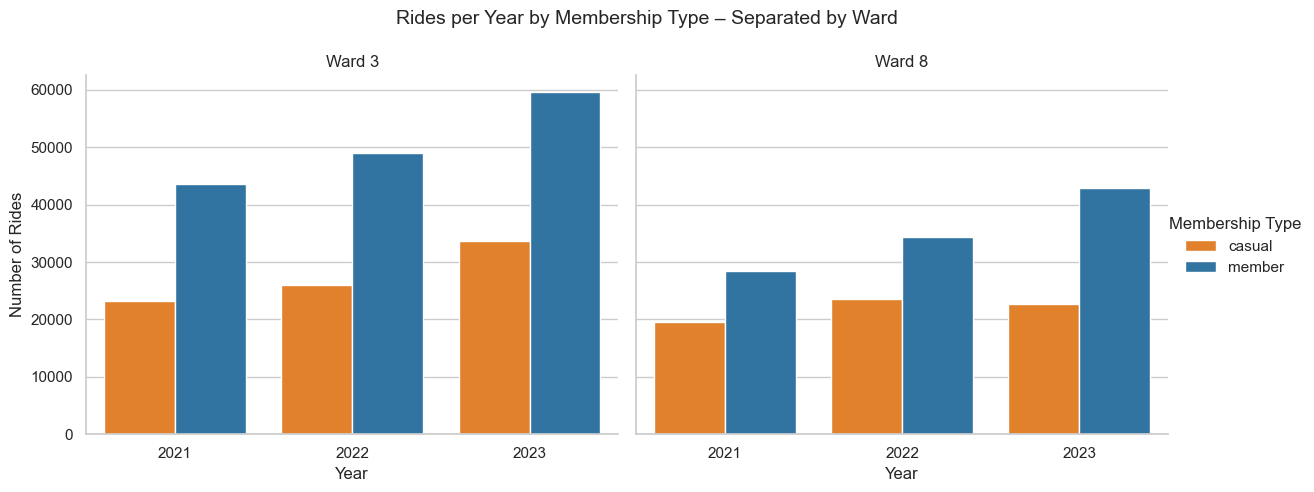

In [38]:
# 1. Convert datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extract year
CBS_Wards_df['year'] = CBS_Wards_df['started_at'].dt.year

# 3. Filter Ward 3 and Ward 8
filtered_df = CBS_Wards_df[CBS_Wards_df['NAME'].isin(['Ward 3', 'Ward 8'])]

# 4. Group by year, ward, and member type
grouped = (
    filtered_df.groupby(['year', 'NAME', 'member_casual'])
    .size()
    .reset_index(name='ride_count')
)

# 5. Plot with seaborn FacetGrid
sns.set(style="whitegrid")
g = sns.catplot(
    data=grouped,
    x="year",
    y="ride_count",
    hue="member_casual",
    col="NAME",
    kind="bar",
    height=5,
    aspect=1.2,
    palette={"member": "#1f77b4", "casual": "#ff7f0e"}
)

g.set_axis_labels("Year", "Number of Rides")
g.set_titles("{col_name}")
g._legend.set_title("Membership Type")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Rides per Year by Membership Type – Separated by Ward", fontsize=14)

plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/3666988494.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CBS_Wards_df.groupby(['year_str', 'member_casual'])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/3666988494.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


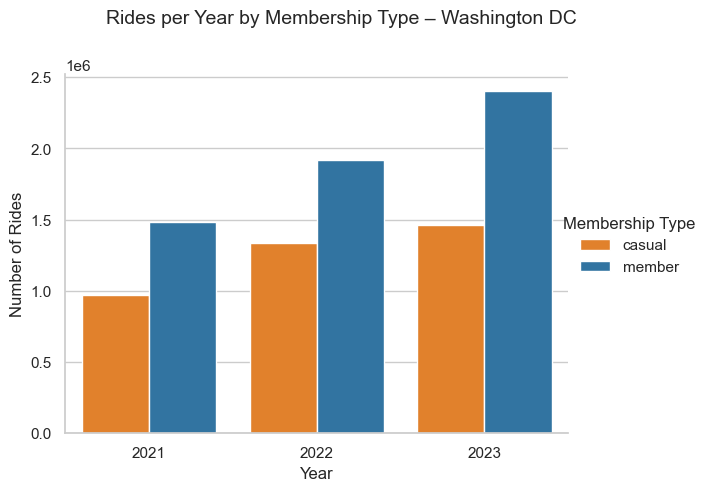

In [39]:

# 1. Convert datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extract year
CBS_Wards_df['year'] = CBS_Wards_df['started_at'].dt.year

# 3. IMPORTANT : transformer en string pour affichage complet des années
CBS_Wards_df['year_str'] = CBS_Wards_df['year'].astype(str)

# 4. Group by year and member type (avec la nouvelle colonne string)
grouped = (
    CBS_Wards_df.groupby(['year_str', 'member_casual'])
    .size()
    .reset_index(name='ride_count')
)

# 5. Plot with seaborn catplot
sns.set(style="whitegrid")
g = sns.catplot(
    data=grouped,
    x="year_str",        # utiliser la colonne string ici
    y="ride_count",
    hue="member_casual",
    kind="bar",
    height=5,
    aspect=1.2,
    palette={"member": "#1f77b4", "casual": "#ff7f0e"}
)

g.set_axis_labels("Year", "Number of Rides")
g.set_titles("{col_name}")
g._legend.set_title("Membership Type")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Rides per Year by Membership Type – Washington DC", fontsize=14)

# Optionnel : s’assurer que tous les labels sont visibles en les tournant un peu
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels())

plt.show()


# KPI: Ride Number per Station. Evolution per year: 

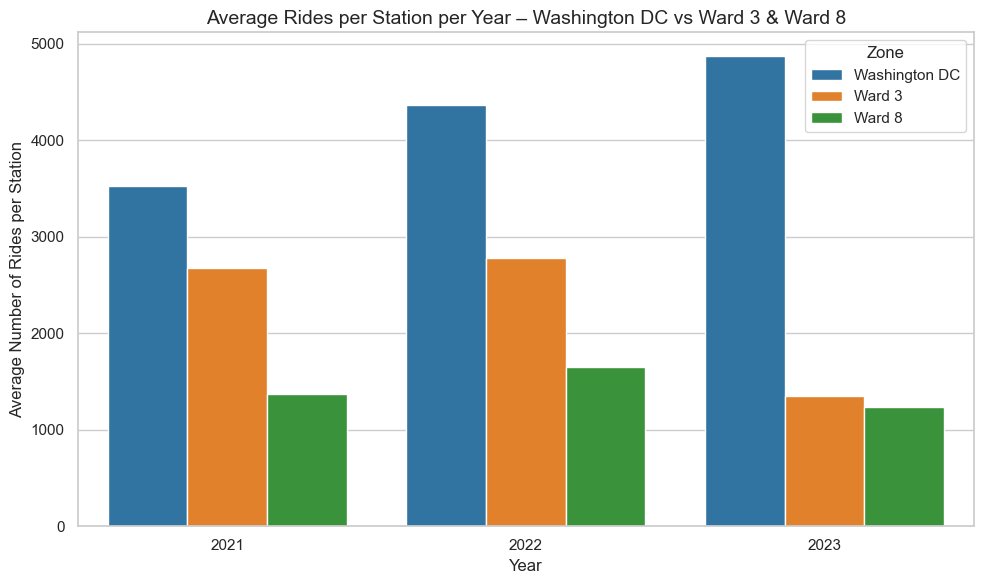

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Convert datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extract year
CBS_Wards_df['year'] = CBS_Wards_df['started_at'].dt.year

# 3. Filtrer Ward 3 et 8
wards_df = CBS_Wards_df[CBS_Wards_df['NAME'].isin(["Ward 3", "Ward 8"])]

# 4. Calcul pour Ward 3 et 8
rides_wards = wards_df.groupby(['year', 'NAME'])['ride_id'].count().reset_index(name='total_rides')
stations_wards = wards_df.groupby(['year', 'NAME'])['start_station_name'].nunique().reset_index(name='unique_stations')

merged_wards = pd.merge(rides_wards, stations_wards, on=['year', 'NAME'])
merged_wards['rides_per_station'] = merged_wards['total_rides'] / merged_wards['unique_stations']
merged_wards['year_str'] = merged_wards['year'].astype(str)
merged_wards['zone'] = merged_wards['NAME']  # "Ward 3" or "Ward 8"

# 5. Calcul pour Washington DC global (sans filtre)
rides_dc = CBS_Wards_df.groupby('year')['ride_id'].count().reset_index(name='total_rides')
stations_dc = CBS_Wards_df.groupby('year')['start_station_name'].nunique().reset_index(name='unique_stations')

merged_dc = pd.merge(rides_dc, stations_dc, on='year')
merged_dc['rides_per_station'] = merged_dc['total_rides'] / merged_dc['unique_stations']
merged_dc['year_str'] = merged_dc['year'].astype(str)
merged_dc['zone'] = "Washington DC"

# 6. Combiner les données
final_df = pd.concat([
    merged_dc[['year', 'year_str', 'zone', 'rides_per_station']],
    merged_wards[['year', 'year_str', 'zone', 'rides_per_station']],
    ])

# 7. Tracer
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=final_df,
    x='year_str',
    y='rides_per_station',
    hue='zone',
    palette='tab10'
)

# 8. Esthétique en anglais
plt.title("Average Rides per Station per Year – Washington DC vs Ward 3 & Ward 8", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Number of Rides per Station")
plt.xticks(rotation=0)
plt.legend(title="Zone")

plt.tight_layout()
plt.show()


In [74]:
import pandas as pd

# 1. S'assurer que la colonne datetime est bien convertie
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extraire l’année
CBS_Wards_df['year'] = CBS_Wards_df['started_at'].dt.year

# 3. Calculer le nombre unique de stations de départ par année
stations_per_year = CBS_Wards_df.groupby('year')['start_station_name'].nunique().reset_index()
stations_per_year.columns = ['year', 'number_of_stations']

# 4. Afficher le résultat
print(stations_per_year)


   year  number_of_stations
0  2021                 697
1  2022                 745
2  2023                 793


In [75]:
import pandas as pd

# 1. Convertir en datetime (si ce n’est pas déjà fait)
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Extraire l’année
CBS_Wards_df['year'] = CBS_Wards_df['started_at'].dt.year

# 3. Filtrer Ward 3 et Ward 8
wards_df = CBS_Wards_df[CBS_Wards_df['NAME'].isin(["Ward 3", "Ward 8"])]

# 4. Calculer le nombre de stations uniques par année et par Ward
stations_by_ward = (
    wards_df
    .groupby(['year', 'NAME'])['start_station_name']
    .nunique()
    .reset_index(name='number_of_stations')
)

# 5. Afficher les résultats
print(stations_by_ward)


   year    NAME  number_of_stations
0  2021  Ward 3                  25
1  2021  Ward 8                  35
2  2022  Ward 3                  27
3  2022  Ward 8                  35
4  2023  Ward 3                  69
5  2023  Ward 8                  53


In [82]:
import pandas as pd

# 1. Assurer que 'started_at' est bien en datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# 2. Filtrer uniquement l’année 2023
df_2023 = CBS_Wards_df[CBS_Wards_df['started_at'].dt.year == 2023]

# 3. Comptabiliser les stations uniques par Ward
stations_per_ward_2023 = (
    df_2023
    .groupby('NAME')['start_station_name']
    .nunique()
    .reset_index(name='number_of_stations')
    .sort_values(by='number_of_stations', ascending=False)
)

# 4. Afficher le résultat
print(stations_per_ward_2023)


     NAME  number_of_stations
1  Ward 2                 258
5  Ward 6                 171
0  Ward 1                 165
3  Ward 4                 164
4  Ward 5                 131
2  Ward 3                  69
6  Ward 7                  58
7  Ward 8                  53


# count bike rides 2022 per wards

In [42]:
# Convert 'started_at' column to datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filter for rides in 2022
CBS_Wards_2022_df = CBS_Wards_df[(CBS_Wards_df['started_at'].dt.year == 2022)]

CBS_Wards_2022_df.head(3)

rides_Wards_2022_counts = CBS_Wards_2022_df['NAME'].value_counts().sort_index()
print(rides_Wards_2022_counts)


NAME
Ward 1     427001
Ward 2    1307638
Ward 3      74921
Ward 4      53412
Ward 5     187390
Ward 6     739122
Ward 7      40526
Ward 8      57927
Name: count, dtype: int64


In [43]:
# Convert 'started_at' column to datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filter for rides in 2022
CBS_Wards_2023_df = CBS_Wards_df[(CBS_Wards_df['started_at'].dt.year == 2023)]

CBS_Wards_2023_df.head(3)

rides_Wards_2023_counts = CBS_Wards_2023_df['NAME'].value_counts().sort_index()
print(rides_Wards_2023_counts)


NAME
Ward 1     516869
Ward 2    1483145
Ward 3      93226
Ward 4      75758
Ward 5     239193
Ward 6     890880
Ward 7      45699
Ward 8      65519
Name: count, dtype: int64


In [44]:
# Convert 'started_at' column to datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filter for rides in 2022
CBS_Wards_2022_df = CBS_Wards_df[(CBS_Wards_df['started_at'].dt.year == 2022)]

CBS_Wards_2022_df.head(3)

rides_Wards_2022_counts = CBS_Wards_2022_df['NAME'].value_counts().sort_index()
print(rides_Wards_2022_counts)


NAME
Ward 1     427001
Ward 2    1307638
Ward 3      74921
Ward 4      53412
Ward 5     187390
Ward 6     739122
Ward 7      40526
Ward 8      57927
Name: count, dtype: int64


# Plot Rides Mean Distances

In [45]:
def calculate_distance(row):
    start = (row['start_lat'], row['start_lng'])
    end = (row['end_lat'], row['end_lng'])
    return geodesic(start, end).kilometers  # ou .kilometers selon l’unité souhaitée

CBS_Wards_2022_df['distance_m'] = CBS_Wards_2022_df.apply(calculate_distance, axis=1)

/opt/anaconda3/envs/CodeAcademyBasics/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [84]:
print(CBS_Wards_2022_df.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'season', 'Days_Off', 'ride_duration_min', 'hour',
       'month', 'geometry', 'geometry_end', 'index_right', 'NAME', 'year',
       'year_str', 'distance_km'],
      dtype='object')


In [47]:
# Moyenne des distances par ward (colonne "NAME")
average_distance_per_ward = CBS_Wards_2022_df.groupby('NAME')['distance_m'].mean().reset_index()

# Renommer la colonne pour plus de clarté
average_distance_per_ward = average_distance_per_ward.rename(columns={'distance_m': 'mean_distance_km'})

# Afficher les résultats
print(average_distance_per_ward)


     NAME  mean_distance_km
0  Ward 1          2.066760
1  Ward 2          1.711165
2  Ward 3          2.438872
3  Ward 4          2.673352
4  Ward 5          2.059587
5  Ward 6          1.806412
6  Ward 7          2.132026
7  Ward 8          2.039853


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/893454780.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/893454780.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars2 = sns.barplot(


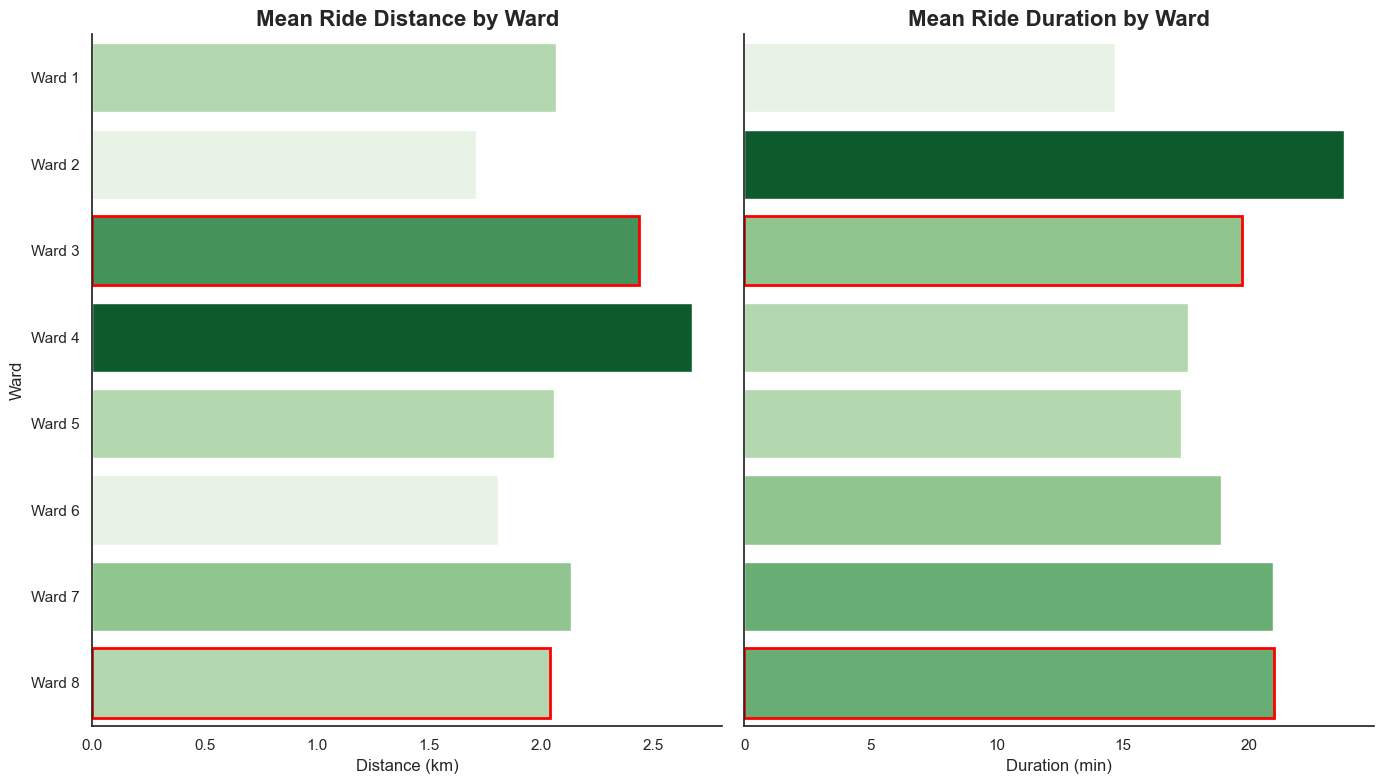

In [85]:
# Appliquer un style épuré
sns.set_style("white")

# Calculer les moyennes par ward
average_metrics_per_ward = CBS_Wards_2022_df.groupby('NAME')[['distance_km', 'ride_duration_min']].mean().reset_index()

# Extraire les numéros de ward pour trier
average_metrics_per_ward['ward_number'] = average_metrics_per_ward['NAME'].str.extract(r'(\d+)').astype(int)

# Trier par numéro de ward
df_ordered = average_metrics_per_ward.sort_values(by='ward_number').reset_index(drop=True)

# Normaliser les valeurs pour la couleur
def get_ordered_colors(values, palette_name="Greens"):
    norm = (values - values.min()) / (values.max() - values.min())
    base_palette = sns.color_palette(palette_name, n_colors=len(values))
    return [base_palette[int(i * (len(base_palette) - 1))] for i in norm]

# Couleurs basées sur les valeurs
colors_distance = get_ordered_colors(df_ordered["distance_km"])
colors_duration = get_ordered_colors(df_ordered["ride_duration_min"])

# Créer la figure et les axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharey=True)

# === Graphique 1 : Distance moyenne ===
bars1 = sns.barplot(
    data=df_ordered,
    y="NAME", x="distance_km",
    palette=colors_distance,
    ax=ax1
)
ax1.set_title("Mean Ride Distance by Ward", fontsize=16, weight='bold')
ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Ward")

# Encadrer Ward 3 et 8 en rouge
highlight_wards = ["Ward 3", "Ward 8"]
for bar, name in zip(ax1.patches, df_ordered["NAME"]):
    if name in highlight_wards:
        bar.set_edgecolor("red")
        bar.set_linewidth(2)

# === Graphique 2 : Durée moyenne ===
bars2 = sns.barplot(
    data=df_ordered,
    y="NAME", x="ride_duration_min",
    palette=colors_duration,
    ax=ax2
)
ax2.set_title("Mean Ride Duration by Ward", fontsize=16, weight='bold')
ax2.set_xlabel("Duration (min)")
ax2.set_ylabel("")

# Encadrer Ward 3 et 8 en rouge
for bar, name in zip(ax2.patches, df_ordered["NAME"]):
    if name in highlight_wards:
        bar.set_edgecolor("red")
        bar.set_linewidth(2)

# Retirer les bordures
sns.despine()

# Afficher le tout
plt.tight_layout()
plt.show()


Ward 3 Topographie: Hill untill 140m / Ward 8 Topographie: Hill until 70m.

# Corelation Heatmap

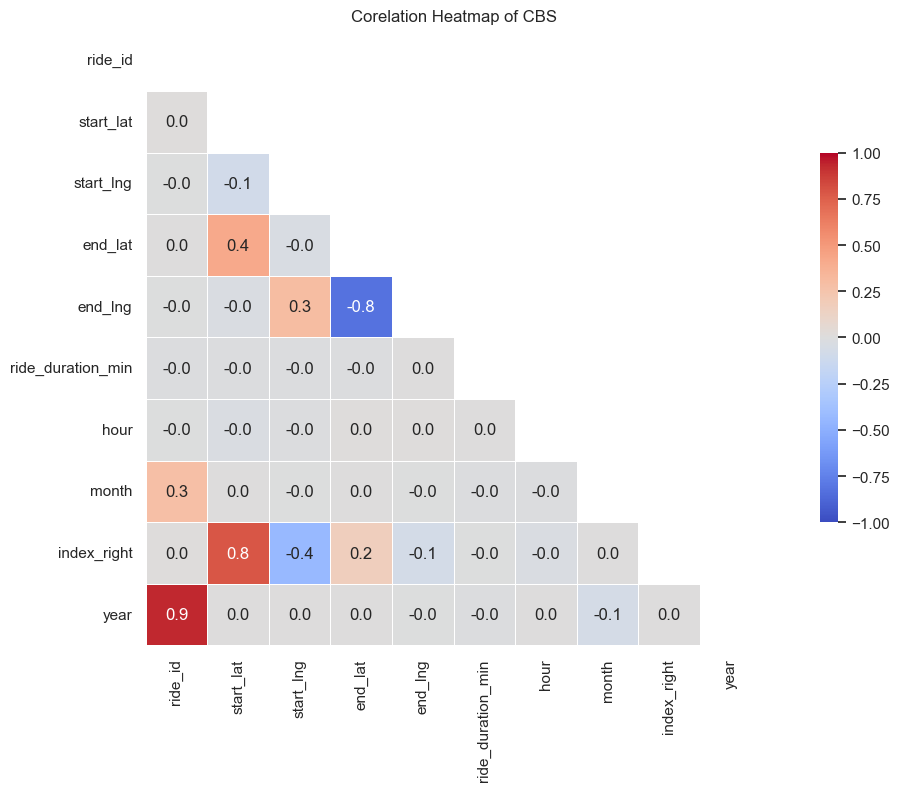

In [49]:
fig = plt.gcf()  
fig.set_size_inches(15, 8)
corr = CBS_Wards_df.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool)) #Generate a mask for the upper triangle

df = CBS_Wards_df.corr(numeric_only=True)

ax = plt.axes()
sns.heatmap(data=df, annot=True, ax = ax, cmap="coolwarm", fmt=".1f", linewidths=0.5, square = True,  vmin=-1, vmax=1, mask=mask, cbar_kws={"shrink": 0.6})
ax.set_title('Corelation Heatmap of CBS')

plt.show()

# Plot Bike Stations vs Rides with hue = member_casual

In [50]:
CBS_Wards_2022_df.rename(columns={'distance_m': 'distance_km'}, inplace=True)


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/2001803742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBS_Wards_2022_df.rename(columns={'distance_m': 'distance_km'}, inplace=True)


In [87]:
filtered_df = CBS_Wards_2022_df[
    (CBS_Wards_2022_df['ride_duration_min'] > 0) &     
    (CBS_Wards_2022_df['ride_duration_min'] < 180) &   # durée < 2h
    (CBS_Wards_2022_df['distance_km'] < 25)            # distance < 30 km
]

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/4112888427.py:57: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/CodeAcademyBasics/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


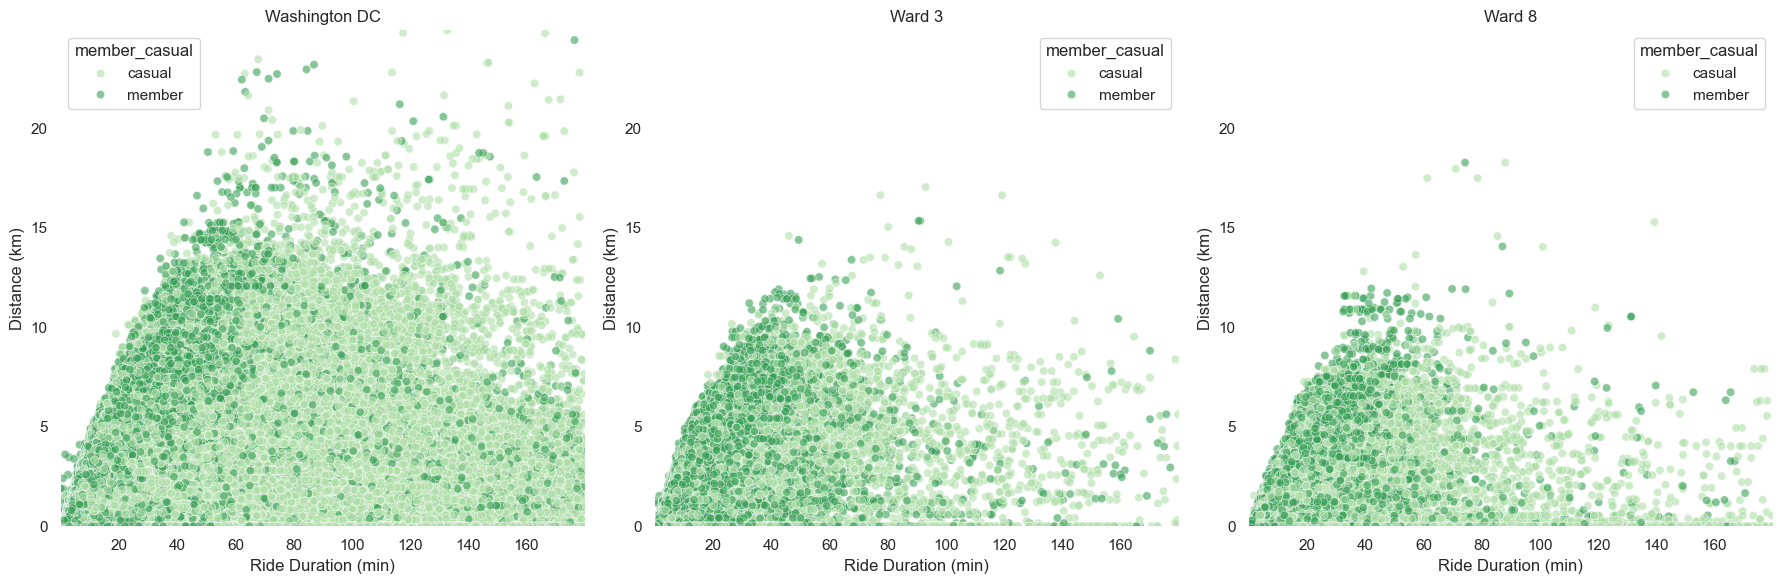

In [52]:
# Définir les limites Y et X communes (si tu veux aussi figer l'axe X)
y_min = filtered_df["distance_km"].min()
y_max = filtered_df["distance_km"].max()

x_min = filtered_df["ride_duration_min"].min()
x_max = filtered_df["ride_duration_min"].max()

# Créer la figure et les axes
f, axes = plt.subplots(1, 3, figsize=(18, 6))

# Supprimer les bordures
for ax in axes:
    sns.despine(f, ax=ax, left=True, bottom=True)

# Graphique 1 : Washington DC (toutes les données)
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=filtered_df, ax=axes[0]
)
axes[0].set_title("Washington DC")
axes[0].set_xlabel("Ride Duration (min)")
axes[0].set_ylabel("Distance (km)")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

# Graphique 2 : Ward 3
ward3_df = filtered_df[filtered_df["NAME"] == "Ward 3"]
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=ward3_df, ax=axes[1]
)
axes[1].set_title("Ward 3")
axes[1].set_xlabel("Ride Duration (min)")
axes[1].set_ylabel("Distance (km)")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

# Graphique 3 : Ward 8
ward8_df = filtered_df[filtered_df["NAME"] == "Ward 8"]
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=ward8_df, ax=axes[2]
)
axes[2].set_title("Ward 8")
axes[2].set_xlabel("Ride Duration (min)")
axes[2].set_ylabel("Distance (km)")
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(y_min, y_max)

# Réglage de la mise en page
plt.tight_layout()
plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/284588196.py:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/opt/anaconda3/envs/CodeAcademyBasics/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


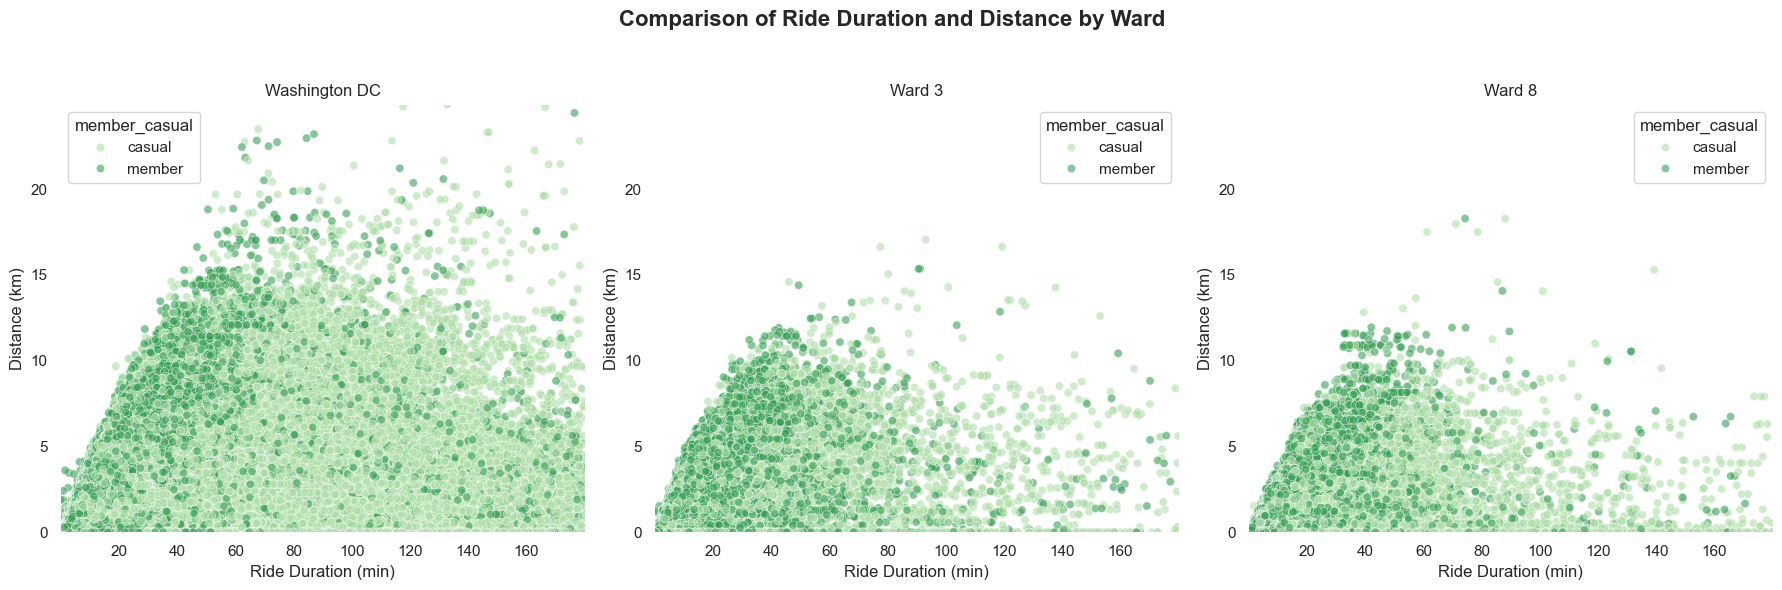

In [88]:
# Définir les limites Y et X communes
y_min = filtered_df["distance_km"].min()
y_max = filtered_df["distance_km"].max()

x_min = filtered_df["ride_duration_min"].min()
x_max = filtered_df["ride_duration_min"].max()

# Créer la figure et les axes
f, axes = plt.subplots(1, 3, figsize=(18, 6))

# Supprimer les bordures
for ax in axes:
    sns.despine(f, ax=ax, left=True, bottom=True)

# Graphique 1 : Washington DC (toutes les données)
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=filtered_df, ax=axes[0]
)
axes[0].set_title("Washington DC")
axes[0].set_xlabel("Ride Duration (min)")
axes[0].set_ylabel("Distance (km)")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

# Graphique 2 : Ward 3
ward3_df = filtered_df[filtered_df["NAME"] == "Ward 3"]
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=ward3_df, ax=axes[1]
)
axes[1].set_title("Ward 3")
axes[1].set_xlabel("Ride Duration (min)")
axes[1].set_ylabel("Distance (km)")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

# Graphique 3 : Ward 8
ward8_df = filtered_df[filtered_df["NAME"] == "Ward 8"]
sns.scatterplot(
    y="distance_km", x="ride_duration_min",
    hue="member_casual",
    palette="Greens", alpha=0.6,
    data=ward8_df, ax=axes[2]
)
axes[2].set_title("Ward 8")
axes[2].set_xlabel("Ride Duration (min)")
axes[2].set_ylabel("Distance (km)")
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(y_min, y_max)

# Ajouter le titre général
plt.suptitle("Comparison of Ride Duration and Distance by Ward", fontsize=16, weight='bold')

# Réglage de la mise en page (laisser de l'espace pour le suptitle)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [53]:
print(CBS_Wards_df.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'season', 'Days_Off', 'ride_duration_min', 'hour',
       'month', 'geometry', 'geometry_end', 'index_right', 'NAME', 'year',
       'year_str'],
      dtype='object')


# ML Regression Rides & Stations: days

In [54]:
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'])
CBS_Wards_df['year_month_day'] = CBS_Wards_df['started_at'].dt.to_period('D')  # exemple : '2023-06'

1.2. Calculer : nombre de trajets et nombre de stations utilisées par jour

In [55]:
# Nombre de trajets par mois
ride_counts = CBS_Wards_df.groupby('year_month_day')['ride_id'].count().reset_index()
ride_counts.columns = ['year_month_day', 'ride_count']

# Nombre de stations de départ utilisées par mois
station_counts = CBS_Wards_df.groupby('year_month_day')['start_station_name'].nunique().reset_index()
station_counts.columns = ['year_month_day', 'station_count']

# Fusionner les deux
df_reg = pd.merge(ride_counts, station_counts, on='year_month_day')

In [56]:
X = df_reg[['station_count']]  # Variable explicative : nombre de stations utilisées
y = df_reg['ride_count'] 

print(X.shape)
print(y.shape)

(1095, 1)
(1095,)


In [57]:
X.head()

,station_count
0,274
1,491
2,332
3,418
4,405


In [58]:
y.head()

0     774
1    5130
2    1299
3    2525
4    2552
Name: ride_count, dtype: int64

split the data: train & test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

Train the model

In [60]:

reg_multi_01 = linear_model.LinearRegression()
reg_multi_01.fit(X_train, y_train)

LinearRegression()

Predict values using test data.

In [61]:
reg_multi_score = (reg_multi_01.score(X_test, y_test) * 100)

print(f"R² score (explained variance): {round(reg_multi_score, 2)}%")

R² score (explained variance): 78.42%


Define the attributes for the prediction

In [62]:
attributes = [600]

input_df = pd.DataFrame([attributes], columns=["station_count"])
prediction = reg_multi_01.predict(input_df)

print(f"""A city with the following attributes:
  Station number: {attributes[0]}
Will have around: {round(prediction[0], 1)} Rides per day.
This model explains approximately {round(reg_multi_score, 2)}% of the variance in rides number (R²)
""")


A city with the following attributes:
  Station number: 600
Will have around: 11576.5 Rides per day.
This model explains approximately 78.42% of the variance in rides number (R²)



visualization

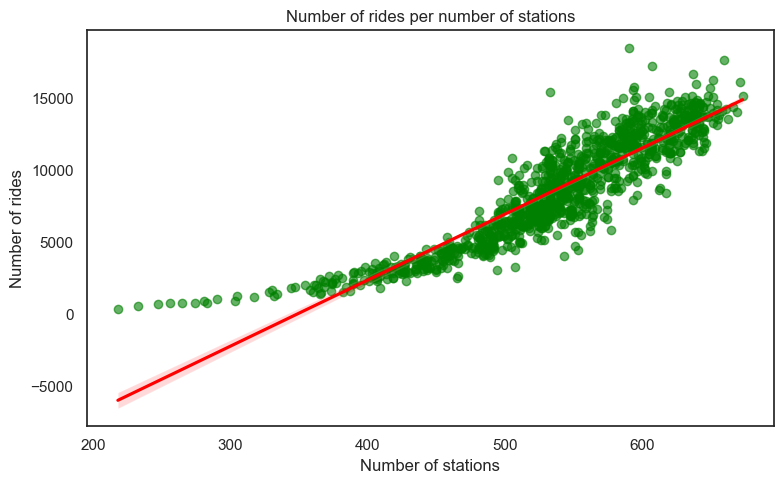

In [63]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_reg,
    x='station_count',
    y='ride_count',
    line_kws={'color': 'red'},
    scatter_kws={'color': 'green', 'alpha': 0.6}
)

plt.title("Number of rides per number of stations")
plt.xlabel("Number of stations")
plt.ylabel("Number of rides")
plt.tight_layout()
plt.show()

# Polynomial Regression with Regularization

In [64]:
# Données
X_all = df_reg[['station_count']].values
y_all = df_reg['ride_count'].values

# Widget pour faire varier le degré du polynôme
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree')

# Boîte de sortie
output = widgets.Output()

def plot_polynomial_regression(degree):
    model = make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=1.0))
    model.fit(X_all, y_all)

  # Calcul du R2
    r2_percent = model.score(X_all, y_all) * 100

    # Génère une plage de valeurs pour tracer la courbe
    X_range = np.linspace(X_all.min(), X_all.max(), 300).reshape(-1, 1)
    y_range_pred = model.predict(X_range)

    # Tracé
    with output:
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.scatter(X_all, y_all, color='green', alpha=0.6)
        plt.plot(X_range, y_range_pred, color='red', linewidth=2)
        plt.title(f"Polynomial Ridge Regression (Degree {degree})\nR2 = {r2_percent:.2f}%")
        plt.xlabel("Number of stations")
        plt.ylabel("Number of rides")
        plt.tight_layout()
        plt.show()

# Connecte le widget à la fonction
widgets.interact(plot_polynomial_regression, degree=degree_slider)

# Affiche le tout
display(output)


interactive(children=(IntSlider(value=2, description='Degree', max=10, min=1), Output()), _dom_classes=('widge…

Output()

# Count member / casual 2023 per wards

In [65]:
# Convertir la colonne 'started_at' en datetime
CBS_Wards_df['started_at'] = pd.to_datetime(CBS_Wards_df['started_at'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

# Filtrer les trajets de l'année 2023
CBS_Wards_2023_df = CBS_Wards_df[CBS_Wards_df['started_at'].dt.year == 2023]

# Compter le nombre de member et casual par ward
rides_per_ward = CBS_Wards_2023_df.groupby(['NAME', 'member_casual']).size().unstack(fill_value=0)

print(rides_per_ward)


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_2374/2640910531.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rides_per_ward = CBS_Wards_2023_df.groupby(['NAME', 'member_casual']).size().unstack(fill_value=0)


member_casual  casual  member
NAME                         
Ward 1         161004  355865
Ward 2         605549  877596
Ward 3          33603   59623
Ward 4          26067   49691
Ward 5          81926  157267
Ward 6         314326  576554
Ward 7          13815   31884
Ward 8          22650   42869
